In [ ]:
import numpy as np

In [ ]:
def calculate_iou_mask(mask1, mask2):
    # mask1 and mask2 should be binary numpy arrays of the same shape
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union
    return iou

def iou_of_mask_sets(set1_masks, set2_masks):
    ious = []
    
    # Ensure the sets are of equal length or handle differently if not
    assert len(set1_masks) == len(set2_masks), "Sets must have the same number of images"
    
    for mask1, mask2 in zip(set1_masks, set2_masks):
        iou = calculate_iou_mask(mask1, mask2)
        ious.append(iou)

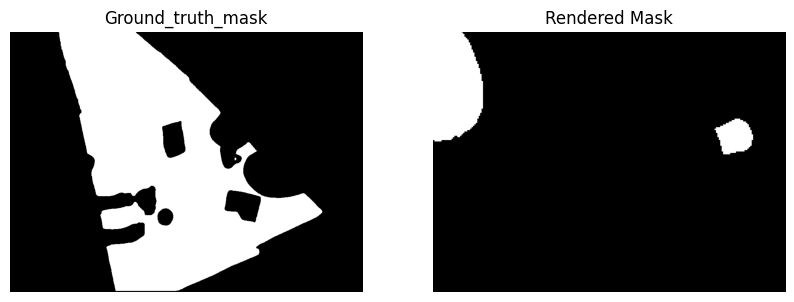

IoU: 0.0000


In [5]:
import numpy as np
from PIL import Image
import cv2 
import matplotlib.pyplot as plt

def load_binary_mask(image_path, target_size=None):
    image = Image.open(image_path).convert("L")  # Convert to grayscale

    # Resize if target_size is provided
    if target_size:
        image = image.resize(target_size, Image.NEAREST)

    # cv2.imshow("mask", image)
    # cv2.waitKey(10)
    mask = np.array(image)  # Convert to NumPy array
    mask = (mask > 128).astype(np.uint8)  # Threshold to create binary mask (0 or 1)
    return mask

def calculate_iou_from_paths(mask1_path, mask2_path):
    # Load first mask and get its size
    mask1 = load_binary_mask(mask1_path)
    h, w = mask1.shape  # Get height and width of first mask

    # Load second mask with resizing to match first mask's size
    mask2 = load_binary_mask(mask2_path, target_size=(w, h))

    # Compute IoU
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0  # Avoid division by zero
    fig,axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(mask1, cmap="gray")
    axes[0].set_title("Ground_truth_mask")
    axes[0].axis("off")

    axes[1].imshow(mask2, cmap="gray")
    axes[1].set_title("Rendered Mask")
    axes[1].axis("off")

    plt.show()
    
    return iou

# Example usage:
mask1_path = "masks/table_1671043827.png"
mask2_path = "/home/siddharth/siddharth/thesis/Yolo_segmentation/test_0.jpg"

iou_value = calculate_iou_from_paths(mask1_path, mask2_path)
print(f"IoU: {iou_value:.4f}")


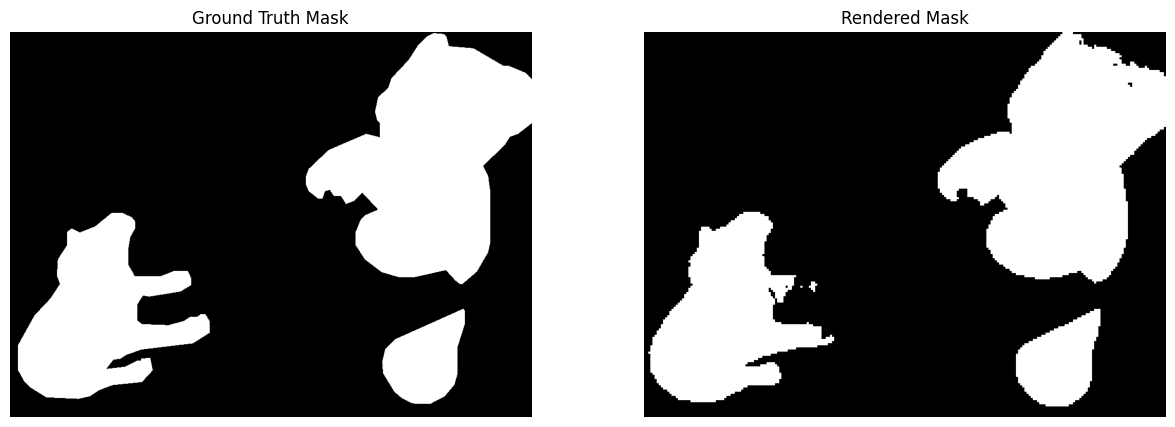

IoU: 0.9191


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_binary_mask(image_path, target_size=None):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    # print(image.size, target_size)

    # Resize if target_size is provided
    if target_size:
        image = image.resize(target_size, Image.NEAREST)

    mask = np.array(image)  # Convert to NumPy array
    mask = (mask > 0.5*255).astype(np.uint8)  # Threshold to create binary mask (0 or 1)
    return mask

def merge_masks(mask1, mask2):
    return np.logical_or(mask1, mask2).astype(np.uint8)  # Merge by logical OR

def calculate_iou_from_paths(mask1_path, mask1_1_path, mask2_path):
    # Load first and second ground truth masks
    mask1 = load_binary_mask(mask1_path)
    mask1_1 = load_binary_mask(mask1_1_path, target_size=mask1.shape[::-1])
    
    # Merge both ground truth masks
    merged_mask = merge_masks(mask1, mask1_1)
    
    # Load rendered mask with resizing to match merged mask's size
    mask2 = load_binary_mask(mask2_path, target_size=merged_mask.shape[::-1])
    
    # Compute IoU
    intersection = np.logical_and(merged_mask, mask2)
    union = np.logical_or(merged_mask, mask2)
    
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0  # Avoid division by zero
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(merged_mask, cmap="gray")
    axes[0].set_title("Ground Truth Mask")
    axes[0].axis("off")
    
    # axes[1].imshow(mask1_1, cmap="gray")
    # axes[1].set_title("Ground Truth Mask 2")
    # axes[1].axis("off")
    
    axes[1].imshow(mask2, cmap="gray")
    axes[1].set_title("Rendered Mask")
    axes[1].axis("off")
    plt.show()
    
    return iou

# Example usage:

mask1_path = "/home/siddharth/siddharth/thesis/Yolo_segmentation/eval_datasets/teatime/test_mask/0/stuffed bear.png" # grnd truth 1
mask1_1_path = "/home/siddharth/siddharth/thesis/Yolo_segmentation/eval_datasets/teatime/test_mask/0/sheep.png"   # grnd truth 2

mask2_path = "/home/siddharth/siddharth/thesis/Yolo_segmentation/test_0.jpg"

iou_value = calculate_iou_from_paths(mask1_path, mask1_1_path, mask2_path)
print(f"IoU: {iou_value:.4f}")


https://www.spized.com/en/configurator?cfg-id=85fa7ffada04cf42ff4650e64ef8a1a0d873ef61708cdaffd171df1e171c58e351ac08aa1aea6f11b0bbce69f3d166248fc0be60b944761876e703f6c1bcfe6d&uuid=cee2711c3ab6434b98c7511b28588902

In [4]:
import json
import base64
import zlib
import numpy as np
import cv2
import os

def extract_masks(json_path, output_dir):
    # Load the JSON file
    with open(json_path, 'r') as f:
        annotation = json.load(f)

    img_height = annotation["annotation"]["size"]["height"]
    img_width = annotation["annotation"]["size"]["width"]

    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

    for obj in annotation["annotation"]["objects"]:
        if obj["geometryType"] == "bitmap":
            try:
                # Decode base64 and decompress using zlib
                mask_data_compressed = base64.b64decode(obj["bitmap"]["data"])
                mask_data = zlib.decompress(mask_data_compressed)  

                # Convert to NumPy array
                mask_array = np.frombuffer(mask_data, dtype=np.uint8)

                # Convert to image using OpenCV
                mask_image = cv2.imdecode(mask_array, cv2.IMREAD_GRAYSCALE)
                if mask_image is None:
                    print(f"Error decoding mask for object {obj['id']}")
                    continue

                # Create an empty mask with the original image size
                full_mask = np.zeros((img_height, img_width), dtype=np.uint8)

                # Get the mask origin position
                origin_x, origin_y = obj["bitmap"]["origin"]

                # Place the decoded mask in the correct position
                h, w = mask_image.shape
                full_mask[origin_y:origin_y+h, origin_x:origin_x+w] = mask_image

                # Save the mask as an image
                mask_filename = os.path.join(output_dir, f"{obj['classTitle']}_{obj['id']}.png")
                cv2.imwrite(mask_filename, full_mask)
                print(f"Saved mask: {mask_filename}")

            except Exception as e:
                print(f"Error processing mask for object {obj['id']}: {e}")

# Example usage
json_path = "eval_datasets/figurines/annotations/figurines_dataset 2025-03-27 22-51-41_test_3.jpg.json"  # Path to your Supervisely JSON file
output_dir = "mask_test_3"  # Directory to save masks
extract_masks(json_path, output_dir)


Saved mask: mask_test_3/dining table_1674922867.png
Saved mask: mask_test_3/apple_1674927812.png


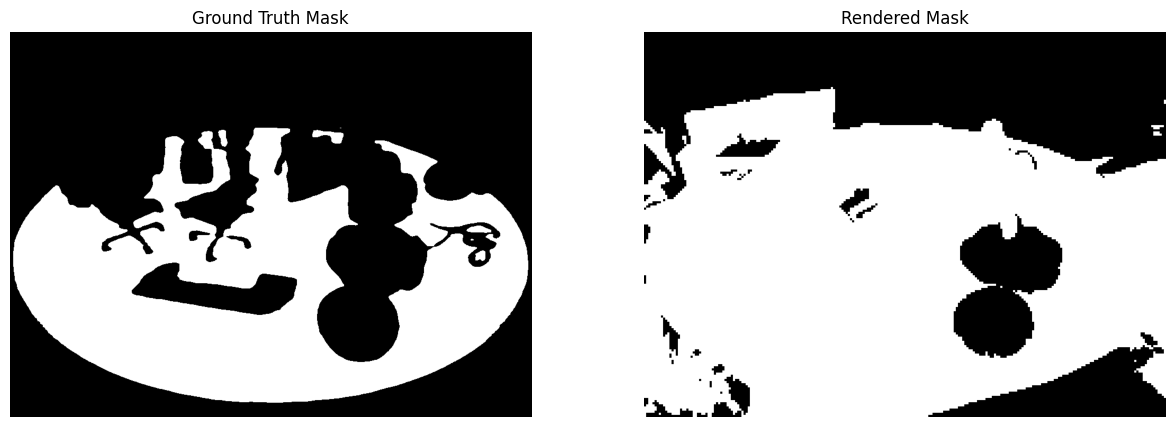

IoU: 0.5722


In [65]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_binary_mask(image_path, target_size=None):
    image = Image.open(image_path).convert("L")  # Convert to grayscale

    # Resize if target_size is provided
    if target_size:
        image = image.resize(target_size, Image.NEAREST)

    mask = np.array(image)  # Convert to NumPy array
    mask = (mask > 0.5*255).astype(np.uint8)  # Threshold to create binary mask (0 or 1)
    return mask

def merge_masks(*masks):
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        merged_mask = np.logical_or(merged_mask, mask).astype(np.uint8)
    return merged_mask

def calculate_iou_from_paths(mask_paths, mask2_path):
    # Load and merge all ground truth masks
    masks = [load_binary_mask(path) for path in mask_paths]
    merged_mask = merge_masks(*masks)
    
    # Load rendered mask with resizing to match merged mask's size
    mask2 = load_binary_mask(mask2_path, target_size=merged_mask.shape[::-1])
    
    # Compute IoU
    intersection = np.logical_and(merged_mask, mask2)
    union = np.logical_or(merged_mask, mask2)
    
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0  # Avoid division by zero
    
    # fig, axes = plt.subplots(1, len(mask_paths) + 1, figsize=(5 * (len(mask_paths) + 1), 5))
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # for i, mask in enumerate(masks):
    axes[0].imshow(merged_mask, cmap="gray")
    axes[0].set_title(f"Ground Truth Mask")
    axes[0].axis("off")
    
    axes[-1].imshow(mask2, cmap="gray")
    axes[-1].set_title("Rendered Mask")
    axes[-1].axis("off")
    
    plt.show()
    
    return iou

# Example usage:
mask_paths = [
    # "/home/siddharth/siddharth/thesis/Yolo_segmentation/mask_test_0/chair_1671043952.png",
    # "/home/siddharth/siddharth/thesis/Yolo_segmentation/mask_test_0/chair_1671044018.png",
    # "mask_test_2/table_1674556854.png",
    # "eval_datasets/teatime/mask/mask_test_0/chair_1671043952.png",
    # "eval_datasets/teatime/mask/mask_test_0/chair_1671044018.png",
    # "eval_datasets/teatime/mask/mask_test_0/chair_1671044096.png",
    # "eval_datasets/teatime/mask/mask_test_0/chair_1671044108.png",
    # "eval_datasets/teatime/mask/mask_test_0/chair_1671044192.png",
    # "eval_datasets/teatime/mask/mask_test_0/spoon_1674624093.png",
    # "eval_datasets/teatime/mask/mask_test_1/cup_1670987964.png",
    # "eval_datasets/teatime/mask/mask_test_1/teddy bear_1674694435.png",
    # "eval_datasets/teatime/mask/mask_test_1/teddy bear_1674694440.png",
    # "eval_datasets/teatime/test_mask/0/sheep.png",
    # "eval_datasets/teatime/test_mask/2/sheep.png",
    # "eval_datasets/teatime/mask/mask_test_2/cup_1671043347.png",
    # "eval_datasets/ramen/masks/mask_00131/bowl_1674071303.png",
    # "eval_datasets/ramen/masks/mask_00131/dining table_1674037111.png",
    # "eval_datasets/ramen/masks/mask_00131/cup_1674037862.png",
    # "eval_datasets/ramen/masks/mask_00131/cup_1674037863.png",
    # "eval_datasets/ramen/masks/mask_test_0/bottle_1674073676.png",
    # "eval_datasets/ramen/masks/mask_test_0/bowl_1674042030.png"
    # "eval_datasets/teatime/mask/mask_test_2/chair_1671043393.png",
    # "eval_datasets/ramen/masks/mask_test_0/cup_1674037703.png",
    # "eval_datasets/ramen/masks/mask_test_1/dining table_1674036521.png",
    # "eval_datasets/ramen/masks/mask_test_1/bowl_1674070652.png",
    # "eval_datasets/ramen/masks/mask_test_0/dining table_1674036421.png",
    # "eval_datasets/ramen/masks/mask_test_1/dining table_1674036521.png",
    # "eval_datasets/ramen/masks/mask_test_1/bowl_1674070652.png"
    # "eval_datasets/ramen/masks/mask_test_1/cup_1674037661.png",
    # "eval_datasets/ramen/masks/mask_test_2/cup_1674037836.png",
    # "eval_datasets/ramen/masks/mask_test_2/cup_1674037783.png",
    # "eval_datasets/ramen/masks/mask_test_2/cup_1674037781.png",
    # "eval_datasets/ramen/masks/mask_test_2/bowl_1674070911.png",
    # "eval_datasets/ramen/masks/mask_test_2/bowl_1674070784.png",
    # "eval_datasets/figurines/masks/mask_test_0/chair_1674922978.png",
    # "eval_datasets/figurines/masks/mask_test_0/apple_1674927803.png"
    # "eval_datasets/figurines/masks/mask_test_0/chair_1674922983.png"
    "eval_datasets/figurines/masks/mask_test_3/dining table_1674922867.png",
    # "/home/siddharth/siddharth/thesis/Yolo_segmentation/eval_datasets/ramen/masks/mask_00131/bowl_1674071303.png"
]

mask2_path = "test_3.jpg" # extracted mask

iou_value = calculate_iou_from_paths(mask_paths, mask2_path)
print(f"IoU: {iou_value:.4f}")
